In [94]:
import math
from math import exp, sqrt, log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy
import xlsxwriter

from scipy import stats
import pylab
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

import sqlite3
from sqlite3 import Error
 
""" create a database connection tool to a SQLite database """
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")


2.6.0


1. Alles von SQL wieder importieren
2. Futures mit Close für Data Cleaning
3. Describe von beiden Tabellen machen


In [95]:
#Select Statement to import the SQL Data back into Python:   
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute("SELECT * FROM MACRO_RAW")
macro_sql_data=c.fetchall()
macro_raw = pd.DataFrame(macro_sql_data,columns=['Macro_Variable', 'DATE', 'Value'])
macro_raw = macro_raw.set_index('DATE')
macro_raw_pivot = macro_raw.pivot(columns='Macro_Variable', values=['Value'])
macro_raw_pivot = macro_raw_pivot.droplevel(level=0, axis=1)

c.execute("SELECT * FROM FUTURES_RAW")
futures_sql_data=c.fetchall()
futures_raw = pd.DataFrame(futures_sql_data,columns=['DATE', 'CLOSE', 'Instrument', 'Return'])
futures_raw = futures_raw.set_index('DATE')
futures_raw_close_pivot = futures_raw.pivot(columns='Instrument', values=['CLOSE']) #ACHTUNG HIER IST CLOSE NICHT RETURN!!
futures_raw_close_pivot = futures_raw_close_pivot.droplevel(level=0, axis=1)

futures_raw_return_pivot = futures_raw.pivot(columns='Instrument', values=['Return']) #ACHTUNG HIER IST RETURN!!
futures_raw_return_pivot = futures_raw_return_pivot.droplevel(level=0, axis=1)

In [96]:
macro_raw_pivot.describe()

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,CNURUA_ECI,EUHICY_ECI,EUPMI_ECI,EUUNR_ECI,RUCPIY_ECI,RUPMIM_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
count,120.000000,120.00000,120.000000,120.000000,120.00000,52.000000,120.000000,49.000000,120.000000,120.000000,33.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.084167,2.96500,54.200000,2.072500,50.51250,5.186538,1.204167,52.934694,9.708333,6.340000,48.203030,5.241667,0.177500,54.350000,5.711667
std,0.729452,0.34584,6.589041,0.983474,1.59698,0.317483,1.035617,6.465374,1.723909,3.622395,4.202342,0.525738,0.254526,4.152755,1.944662
min,-1.400000,2.30000,40.700000,-0.500000,35.70000,4.800000,-0.600000,33.400000,7.000000,2.200000,31.300000,4.300000,-0.800000,41.600000,3.500000
25%,-0.600000,2.80000,49.200000,1.500000,50.10000,5.000000,0.400000,47.700000,8.100000,3.775000,47.500000,4.900000,0.000000,51.250000,4.200000
50%,-0.100000,3.10000,53.700000,2.000000,50.50000,5.100000,1.200000,53.700000,9.650000,5.800000,49.100000,5.200000,0.200000,54.400000,5.150000
75%,0.600000,3.20000,58.300000,2.500000,51.22500,5.300000,1.900000,58.000000,11.500000,7.300000,50.900000,5.600000,0.300000,57.625000,6.750000
max,1.500000,3.50000,70.000000,5.400000,53.30000,6.200000,5.000000,63.400000,12.200000,16.900000,51.900000,6.400000,0.900000,63.700000,14.700000


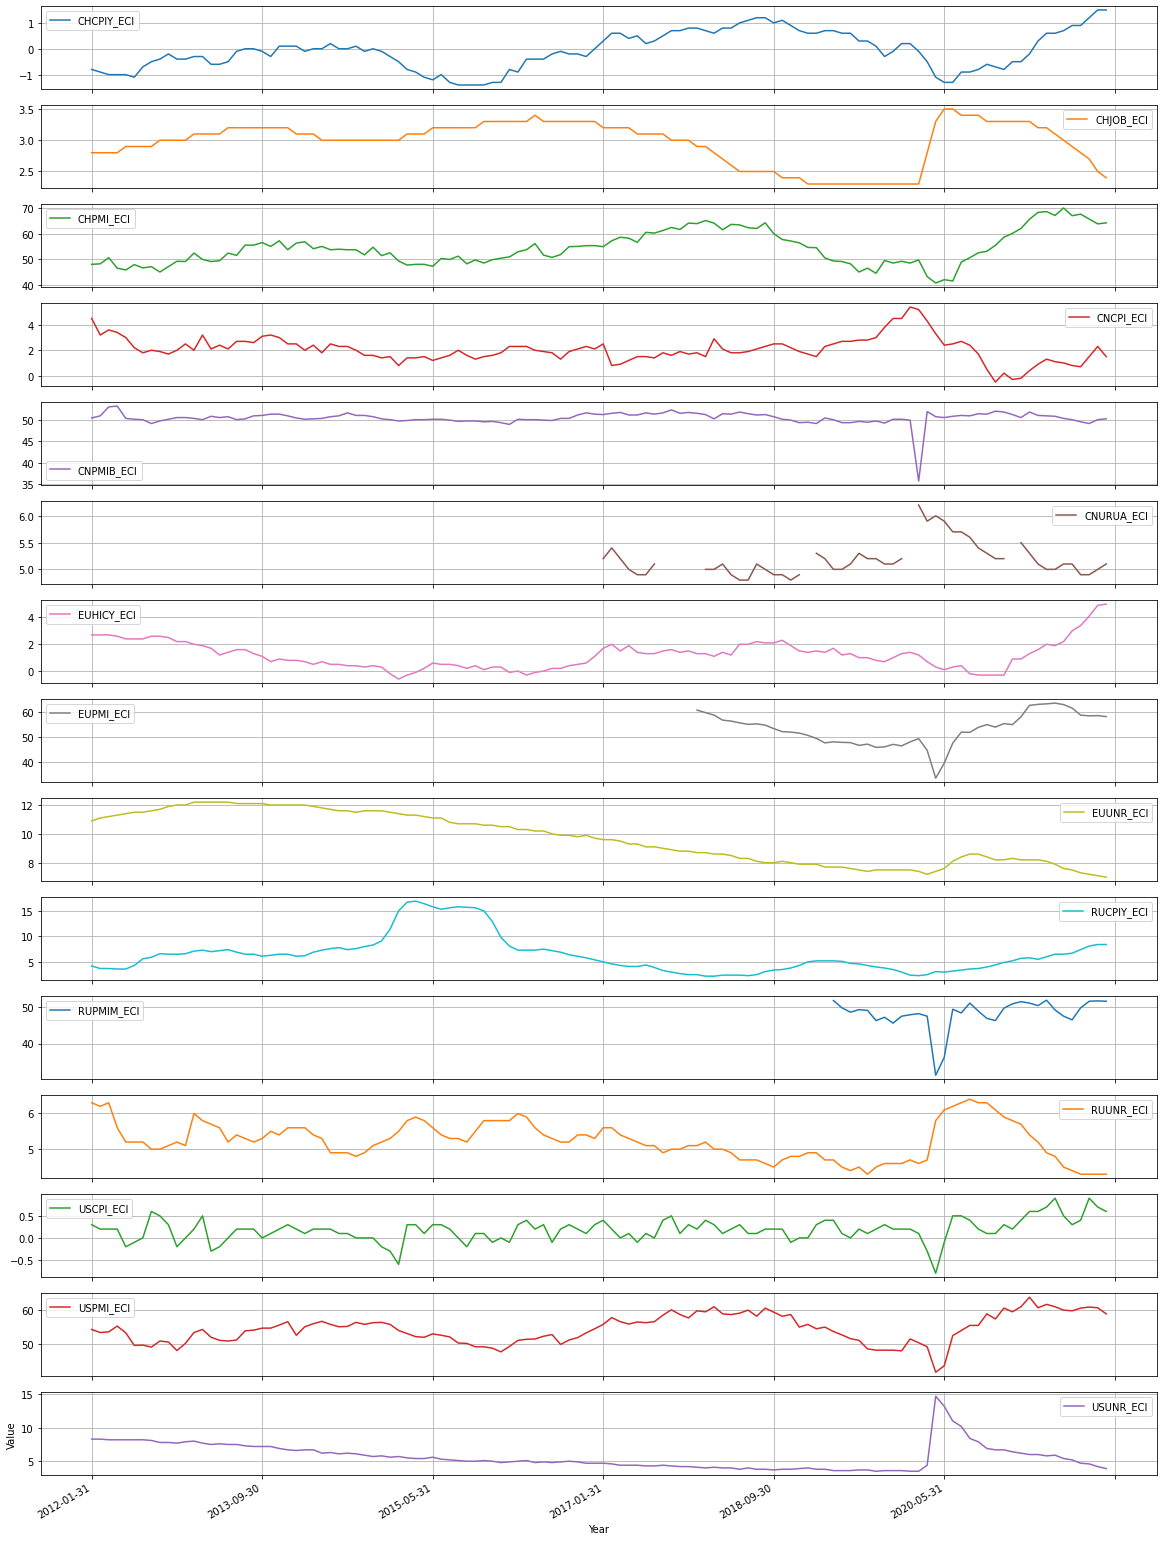

In [97]:
macro_raw_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Makro Line-Charts', dpi=800)

In [98]:
macro_raw_pivot.isna().sum()

Macro_Variable
CHCPIY_ECI     0
CHJOB_ECI      0
CHPMI_ECI      0
CNCPI_ECI      0
CNPMIB_ECI     0
CNURUA_ECI    68
EUHICY_ECI     0
EUPMI_ECI     71
EUUNR_ECI      0
RUCPIY_ECI     0
RUPMIM_ECI    87
RUUNR_ECI      0
USCPI_ECI      0
USPMI_ECI      0
USUNR_ECI      0
dtype: int64

In Marco-Data some Data is missing in the indicators:
- CNURUA_ECI
- EUPMI_ECI
- RUPMIM_ECI

In [99]:
col_to_drop = ['CNURUA_ECI','EUPMI_ECI','RUPMIM_ECI']
macro_clean = macro_raw[macro_raw.Macro_Variable.isin(col_to_drop) == False]
macro_clean

,Macro_Variable,Value
DATE,,
2012-01-31,USUNR_ECI,8.3
2012-02-29,USUNR_ECI,8.3
2012-03-31,USUNR_ECI,8.2
2012-04-30,USUNR_ECI,8.2
2012-05-31,USUNR_ECI,8.2
...,...,...
2021-08-31,RUCPIY_ECI,6.7
2021-09-30,RUCPIY_ECI,7.4
2021-10-31,RUCPIY_ECI,8.1


In [100]:
macro_clean_pivot = macro_raw_pivot.drop(columns=['CNURUA_ECI','EUPMI_ECI','RUPMIM_ECI'], axis=1)
macro_clean_pivot

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,EUHICY_ECI,EUUNR_ECI,RUCPIY_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
DATE,,,,,,,,,,,,
2012-01-31,-0.8,2.8,48.0,4.5,50.5,2.7,10.9,4.2,6.3,0.3,54.2,8.3
2012-02-29,-0.9,2.8,48.2,3.2,51.0,2.7,11.1,3.7,6.2,0.2,53.3,8.3
2012-03-31,-1.0,2.8,50.6,3.6,53.1,2.7,11.2,3.7,6.3,0.2,53.5,8.2
2012-04-30,-1.0,2.8,46.5,3.4,53.3,2.6,11.3,3.6,5.6,0.2,55.2,8.2
2012-05-31,-1.0,2.9,45.8,3.0,50.4,2.4,11.4,3.6,5.2,-0.2,53.2,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.9,2.9,67.0,0.8,50.1,3.0,7.5,6.7,4.4,0.3,59.7,5.2
2021-09-30,0.9,2.8,67.6,0.7,49.6,3.4,7.3,7.4,4.3,0.4,60.5,4.7
2021-10-31,1.2,2.7,65.7,1.5,49.2,4.1,7.2,8.1,4.3,0.9,60.8,4.6


Futures Data:

In [101]:
futures_raw_close_pivot.describe()

Instrument,CLc1,Cc1,GCc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,65.972727,450.522727,1423.401653,124.804132,54.198926,3.064397,135.726860,1150.738430,1112.007438,20.117595,565.995868
std,22.254328,133.158282,240.907383,16.507157,33.657163,0.807724,25.664986,647.639804,261.222126,5.440663,121.885628
min,18.840000,301.500000,1060.300000,90.000000,9.630000,1.640000,94.800000,495.600000,724.400000,13.775000,361.000000
25%,48.520000,358.750000,1240.700000,113.450000,39.500000,2.575000,118.650000,703.000000,908.100000,16.124000,477.000000
50%,60.140000,384.500000,1316.200000,122.075000,49.810000,2.906000,132.950000,819.850000,1001.300000,18.014000,529.750000
75%,88.060000,534.000000,1660.600000,132.925000,60.680000,3.560000,148.350000,1532.000000,1371.100000,23.463000,655.000000
max,107.650000,806.500000,1967.600000,169.500000,251.180000,5.867000,221.950000,2957.700000,1691.100000,34.583000,902.500000


In [102]:
futures_raw_return_pivot.describe()

Instrument,CLc1,Cc1,GCc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.002276,-0.000716,0.001288,0.001020,0.009540,0.001846,-0.001202,0.008903,-0.003104,-0.001484,0.001385
std,0.130546,0.082590,0.042386,0.056496,0.167224,0.121714,0.096164,0.083052,0.062873,0.078962,0.078908
min,-0.781866,-0.308383,-0.129212,-0.163827,-0.414303,-0.450252,-0.234889,-0.260308,-0.174839,-0.193546,-0.208109
25%,-0.057495,-0.037740,-0.025365,-0.026490,-0.074080,-0.058933,-0.060380,-0.031754,-0.043480,-0.053909,-0.056672
50%,0.008843,-0.001432,-0.000174,-0.000086,0.004009,-0.002149,-0.000861,0.024872,-0.004869,-0.009814,0.003019
75%,0.060140,0.038369,0.030713,0.034382,0.074449,0.067967,0.052485,0.056742,0.044977,0.040002,0.043571
max,0.633269,0.271153,0.104223,0.140179,0.676408,0.379753,0.243494,0.222933,0.132332,0.265913,0.253699


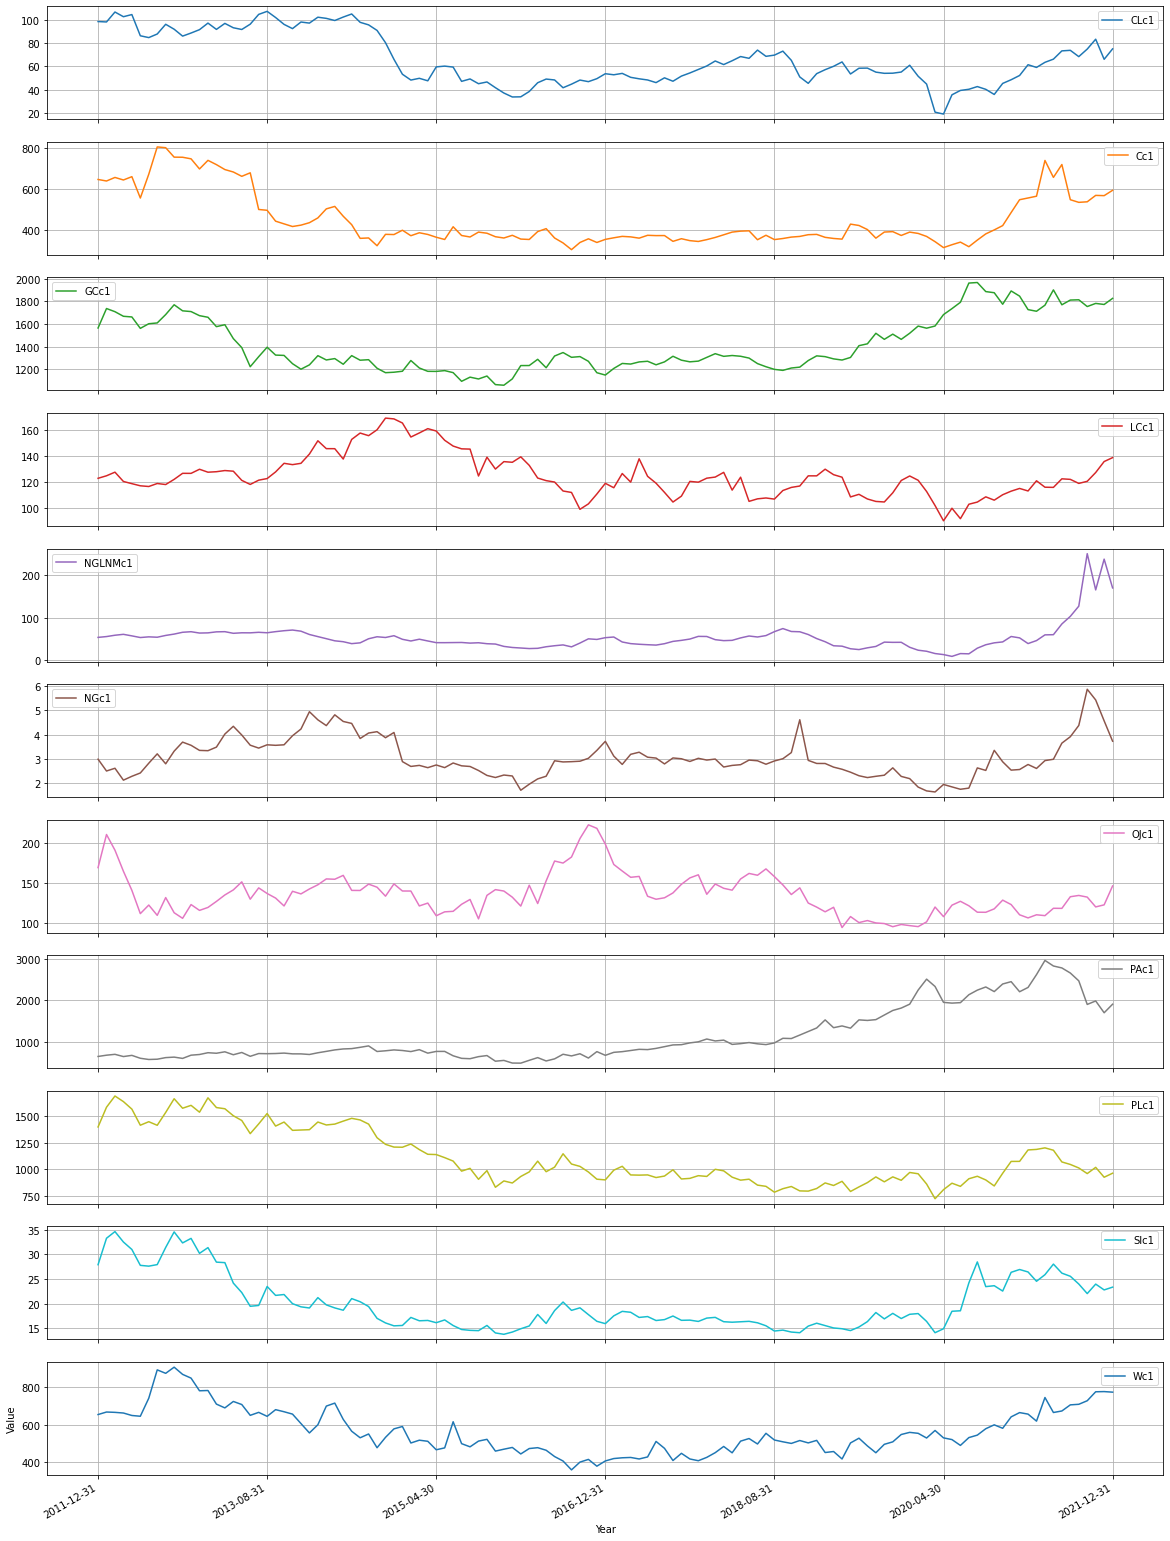

In [103]:
futures_raw_close_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Futures Line-Charts', dpi=800)

Text(0.5, 0, 'Year')

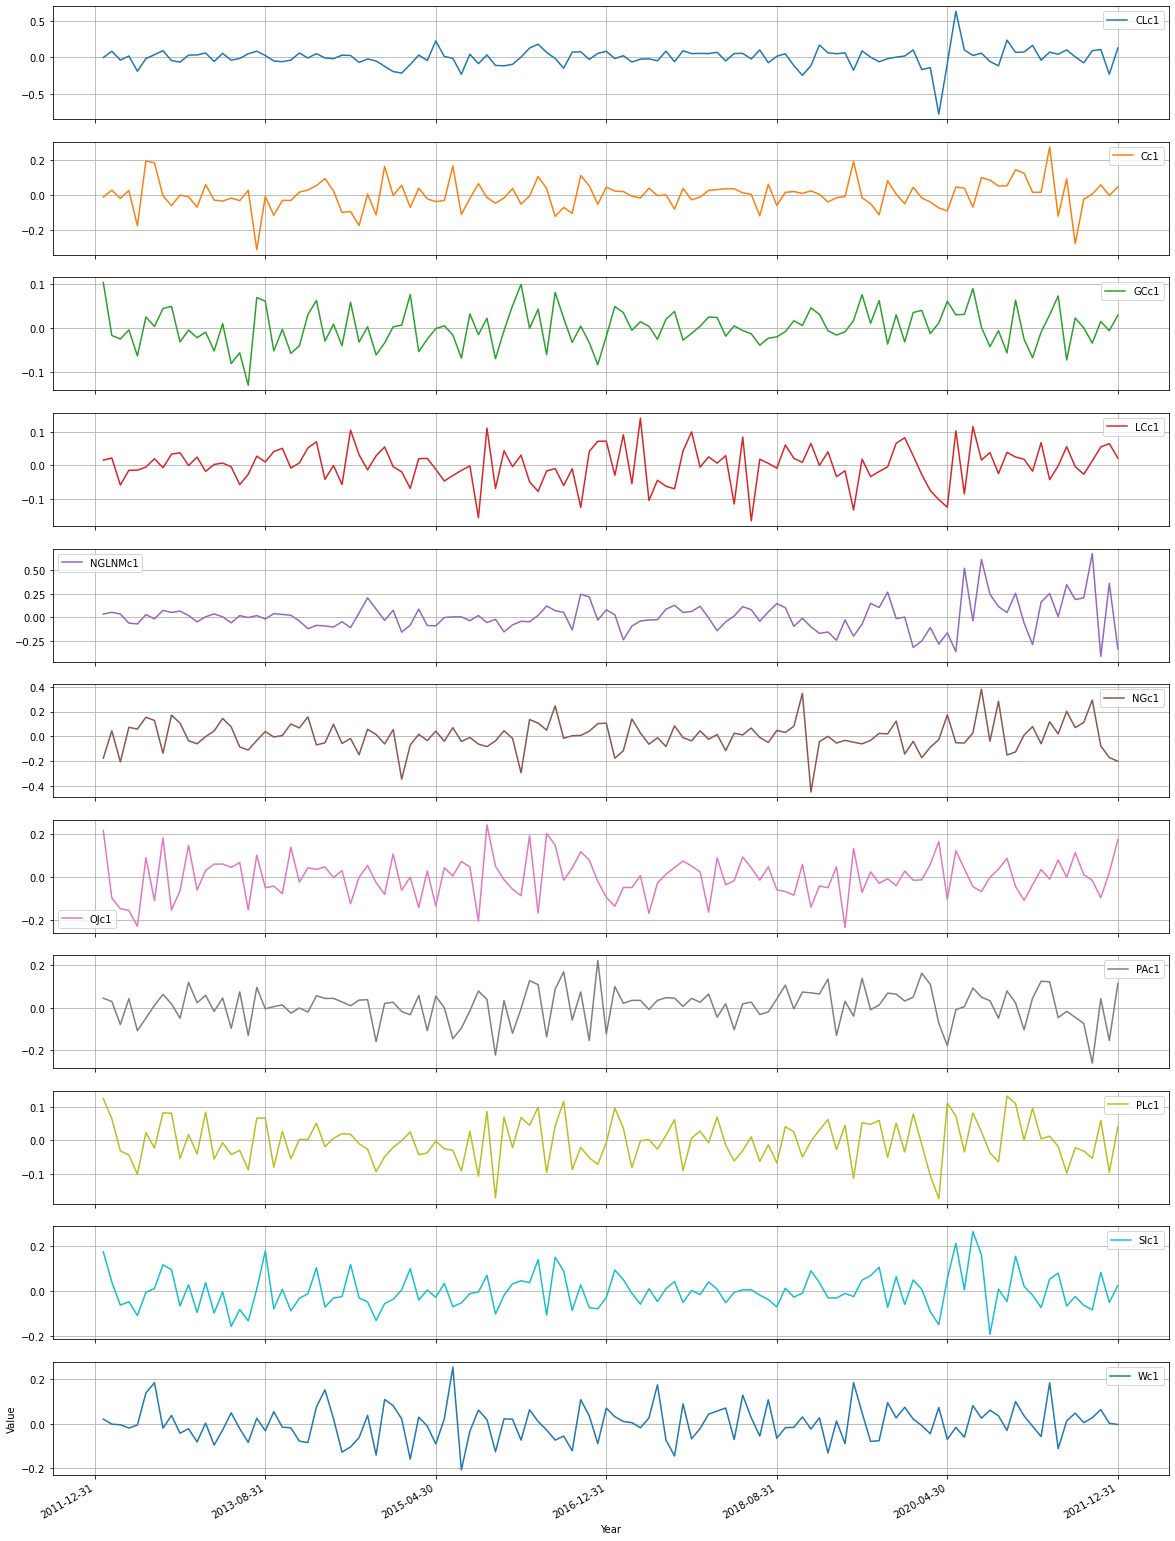

In [104]:
futures_raw_return_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')


In [105]:
futures_raw_close_pivot.isna().sum()

Instrument
CLc1       0
Cc1        0
GCc1       0
LCc1       0
NGLNMc1    0
NGc1       0
OJc1       0
PAc1       0
PLc1       0
SIc1       0
Wc1        0
dtype: int64

In [106]:
#Futures Raw was all good. Drop the first Period, where Returns are empty:
futures_clean_return_pivot = futures_raw_return_pivot.dropna()
futures_clean_return_pivot

futures_clean = futures_raw.dropna()
futures_clean

,CLOSE,Instrument,Return
DATE,,,
2012-01-31,98.48,CLc1,-0.003548
2012-02-29,107.07,CLc1,0.083629
2012-03-31,103.02,CLc1,-0.038560
2012-04-30,104.87,CLc1,0.017798
2012-05-31,86.53,CLc1,-0.192230
...,...,...,...
2021-08-31,706.75,Wc1,0.004254
2021-09-30,725.50,Wc1,0.026184
2021-10-31,772.75,Wc1,0.063095


Save cleaned Data in SQL:

In [107]:
futures_clean = futures_clean.reset_index()
liste_SQL_futures_clean = futures_clean.values.tolist()
futures_clean

macro_clean = macro_clean.reset_index()
liste_SQL_macro_clean = macro_clean.values.tolist()
macro_clean

,DATE,Macro_Variable,Value
0,2012-01-31,USUNR_ECI,8.3
1,2012-02-29,USUNR_ECI,8.3
2,2012-03-31,USUNR_ECI,8.2
3,2012-04-30,USUNR_ECI,8.2
4,2012-05-31,USUNR_ECI,8.2
...,...,...,...
1435,2021-08-31,RUCPIY_ECI,6.7
1436,2021-09-30,RUCPIY_ECI,7.4
1437,2021-10-31,RUCPIY_ECI,8.1
1438,2021-11-30,RUCPIY_ECI,8.4


In [108]:
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''DROP TABLE IF EXISTS MACRO_CLEAN;''')
c.execute('''DROP TABLE IF EXISTS FUTURES_CLEAN;''')

In [109]:
c.execute('''CREATE TABLE MACRO_CLEAN (
    "Macro_Variable" TEXT,
    DATE DATETIME,
	"Value" NUMERIC
);''')

c.execute('''CREATE TABLE FUTURES_CLEAN (
    DATE DATETIME,
	"CLOSE" NUMERIC,
    "Instrument" TEXT,
    "Return" NUMERIC
);''')


In [110]:
conn = sqlite3.connect(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")
c = conn.cursor()
c.executemany("INSERT INTO MACRO_CLEAN(Macro_Variable, DATE, Value) VALUES (?,?,?)", liste_SQL_macro_clean)    
conn.commit()

c.executemany("INSERT INTO FUTURES_CLEAN(DATE, CLOSE, Instrument, Return) VALUES (?,?,?,?)", liste_SQL_futures_clean)    
conn.commit()

In [112]:
#Select Statement to import the SQL Data back into Python:   
c = conn.cursor()
c.execute("SELECT DATE, Macro_Variable, Value FROM MACRO_CLEAN")
macro_sql_data=c.fetchall()
macro_clean_sql = pd.DataFrame(macro_sql_data,columns=['Macro_Variable', 'DATE', 'Value'])
macro_clean_sql = macro_clean_sql.set_index('DATE')
macro_clean_sql

#Select Futures Data from SQL DB:   
c.execute("SELECT * FROM FUTURES_CLEAN")
futures_sql_data=c.fetchall()
futures_clean_sql = pd.DataFrame(futures_sql_data,columns=['DATE', 'CLOSE', 'Instrument', 'Return'])
futures_clean_sql = futures_clean_sql.set_index('DATE')
futures_clean_sql

,CLOSE,Instrument,Return
DATE,,,
2012-01-31,98.48,CLc1,-0.003548
2012-02-29,107.07,CLc1,0.083629
2012-03-31,103.02,CLc1,-0.038560
2012-04-30,104.87,CLc1,0.017798
2012-05-31,86.53,CLc1,-0.192230
...,...,...,...
2021-08-31,706.75,Wc1,0.004254
2021-09-30,725.50,Wc1,0.026184
2021-10-31,772.75,Wc1,0.063095


In [116]:
macro_clean_pivot.to_excel('Files\Macro_clean_pivot.xlsx')
futures_raw_close_pivot.to_excel('Files\Futures_clean_CLOSE_pivot.xlsx')
futures_clean_return_pivot.to_excel('Files\Futures_clean_returns_pivot.xlsx')